<a href="https://colab.research.google.com/github/DhayananthB/HaSy_Recognition/blob/main/Hasy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.optim as optim

In [2]:
 #!pip install deeplake
import deeplake


# Dataset Description
- HASY (Handwritten Symbol Dataset)
- 168,233 instances of 369 classes
- 3X32x32  images

### Reading data

In [3]:
ds = deeplake.load("hub://activeloop/hasy-train")

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/hasy-train



|

hub://activeloop/hasy-train loaded successfully.



train sample size

In [4]:
len(ds)

151241

In [5]:
# ds.visualize()

In [6]:
dt = deeplake.load("hub://activeloop/hasy-test")

/

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/hasy-test



|

hub://activeloop/hasy-test loaded successfully.



test sample size

In [7]:
len(dt)

16992

### transformation

In [8]:
transform_dict = {
    'images': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize with mean=0.5, std=0.5
    ])
}

def custom_transform(sample):
    for key, transform in transform_dict.items():
        if key in sample:
            sample[key] = transform(sample[key])
    return sample

### Data Loading

In [9]:
train_dataloader = ds.pytorch(num_workers=0, batch_size=256, shuffle=True,decode_method={
        'images': 'pil'
    },transform=custom_transform)

In [10]:
test_dataloader = dt.pytorch(num_workers=0, batch_size=256, shuffle=True,decode_method={
        'images': 'pil'
    },transform=custom_transform)

Feature batch shape: torch.Size([256, 3, 32, 32])
Labels batch shape: torch.Size([256, 1])


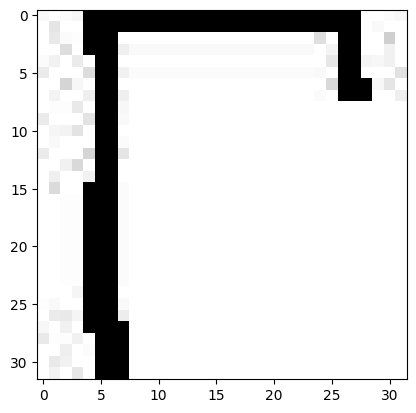

Label: tensor([69])


In [18]:
train_features, train_labels, index = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# For RGB images, no need to use squeeze; directly select the image
img = train_features[0].permute(1, 2, 0)  # Change dimensions from (C, H, W) to (H, W, C)
label = train_labels[0]

# Display the image using matplotlib
plt.imshow(img)
plt.show()

print(f"Label: {label}")

In [11]:
dict(next(iter(test_dataloader))).keys()

dict_keys(['images', 'latex', 'index'])

## Neural Network

In [12]:
class HASYNet(nn.Module):
    def __init__(self):
        super(HASYNet, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Pooling Layer
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1_input_size = 128 * 4 * 4

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.fc1_input_size, 512)
        self.fc2 = nn.Linear(512, 369)  # 369 classes for output

        # Activation
        self.relu = nn.ReLU()

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Forward pass through convolutional layers with ReLU and MaxPool
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        # Flatten the tensor
        x = x.view(-1, self.fc1_input_size)

        # Fully Connected layers with ReLU and Dropout
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # (batch_size, 369) -> Output layer

        return x

In [13]:
device = 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
model = HASYNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
model = HASYNet()  # Assuming HASYNet is defined elsewhere
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 6

# Function to evaluate loss and accuracy
def evaluate_loss_and_accuracy(loader, model, criterion):
    total_loss = 0.0
    correct = 0
    total = 0
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for data in loader:
            inputs = data['images']
            labels = data['latex']

            inputs.to(device)


            labels = labels.squeeze()

            labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    return average_loss, accuracy

# Training and validation loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for i, data in enumerate(train_dataloader, 0):
        inputs = data['images']
        labels = data['latex']

        inputs.to(device)

        labels = labels.squeeze()

        labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Training loss: {running_loss / 100:.3f}")
            running_loss = 0.0

    # Calculate training loss and accuracy
    train_loss, train_accuracy = evaluate_loss_and_accuracy(train_dataloader, model, criterion)
    print(f'Epoch {epoch + 1} Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

    # Calculate validation loss and accuracy
    val_loss, val_accuracy = evaluate_loss_and_accuracy(test_dataloader, model, criterion)
    print(f'Epoch {epoch + 1} Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

print('Finished Training')

[Epoch 1, Batch 100] Training loss: 4.077
[Epoch 1, Batch 200] Training loss: 1.896
[Epoch 1, Batch 300] Training loss: 1.397
[Epoch 1, Batch 400] Training loss: 1.181
[Epoch 1, Batch 500] Training loss: 1.080
Epoch 1 Training Loss: 0.7051, Accuracy: 79.35%
Epoch 1 Validation Loss: 0.6834, Accuracy: 78.62%
[Epoch 2, Batch 100] Training loss: 0.937
[Epoch 2, Batch 200] Training loss: 0.879
[Epoch 2, Batch 300] Training loss: 0.871
[Epoch 2, Batch 400] Training loss: 0.836
[Epoch 2, Batch 500] Training loss: 0.830
Epoch 2 Training Loss: 0.5695, Accuracy: 82.51%
Epoch 2 Validation Loss: 0.5744, Accuracy: 81.50%
[Epoch 3, Batch 100] Training loss: 0.769
[Epoch 3, Batch 200] Training loss: 0.733
[Epoch 3, Batch 300] Training loss: 0.718
[Epoch 3, Batch 400] Training loss: 0.729
[Epoch 3, Batch 500] Training loss: 0.722
Epoch 3 Training Loss: 0.5038, Accuracy: 83.85%
Epoch 3 Validation Loss: 0.5345, Accuracy: 82.15%
[Epoch 4, Batch 100] Training loss: 0.644
[Epoch 4, Batch 200] Training loss

In [16]:
torch.save(model.state_dict(), "hasy.pth")

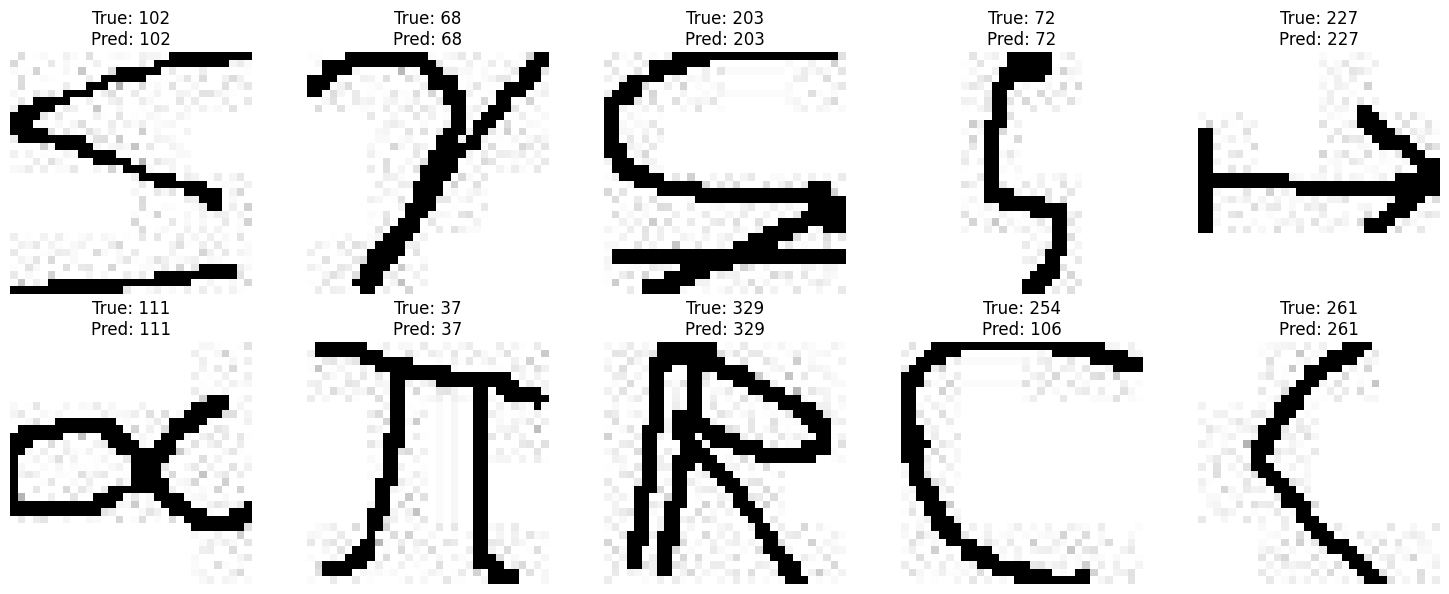

In [21]:
model = HASYNet()
model.load_state_dict(torch.load('/content/hasy.pth'))
model.eval()


data_iter = iter(test_dataloader)
images, labels, indices = next(data_iter)


outputs = model(images)
_, predicted = torch.max(outputs, 1)


fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    img = images[i].permute(1, 2, 0)
    label = labels[i].item()  # Get true label
    pred = predicted[i].item()  # Get predicted label

    axes[i].imshow(img)
    axes[i].set_title(f"True: {label}\nPred: {pred}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()